# Stats for Figure 2

In [44]:
# imports
import pandas as pd
import numpy as np
import sys
sys.path.append('..') # needed for relative file path import with jupyter
from src.cc import ccptpt
from src.expparams import sim_dt
from src.expparams import sim_dur
from src.expparams import sim_step_num
from numpy.random import randint
import h5py
import matplotlib.pyplot as plt

ImportError: cannot import name 'sim_step_num' from 'src.expparams' (/Users/drewbheadley/PythonCode/DendCompOsc/scripts/../src/expparams.py)

In [37]:
# Parameters for this notebook
nmda_bin_dur = 0.005 # nmda event binning size for cc in seconds
nmda_bin_samps = nmda_bin_dur/sim_dt # convert to sample number

NameError: name 'sim_dt' is not defined

### Load data

In [2]:
spikes = h5py.File('../data/spikes.h5','r')
spk_t = np.array(spikes['spikes']['biophysical']['timestamps'])

nmda_evts = pd.read_csv('../data/DendEventTimes/nmda_spk_times.csv')
na_evts = pd.read_csv('../data/DendEventTimes/na_spk_times.csv')

### Group dendritic spike events by electrotonic distance percentile

In [3]:
# create dataframe of node ID and electrotonic percentile

# first combine all dendritic spike dataframes no no node ID is left out
node_elec = pd.concat([nmda_evts[['segmentID', 'Type', 'Elec_distance']], 
                       na_evts[['segmentID', 'Type', 'Elec_distance']]],axis=0)
node_elec = node_elec.drop_duplicates('segmentID')

# calculate percentile rank with dendritic class and bin into 10th percentile steps
node_elec['Elec_dist_prc'] = round(node_elec.groupby('Type')['Elec_distance'].rank(pct=True),1)


# group dendritic events by electrotonic percentile
nmda_evts = nmda_evts.merge(node_elec[['segmentID', 'Elec_dist_prc']],how='inner',on='segmentID')
na_evts = na_evts.merge(node_elec[['segmentID', 'Elec_dist_prc']],how='inner',on='segmentID')

nmda_evts = nmda_evts['nmda_lower_bound_ms'].groupby([nmda_evts['Elec_dist_prc'], nmda_evts['Type']]).apply(np.array)
na_evts = na_evts['na_lower_bound_ms'].groupby([na_evts['Elec_dist_prc'], na_evts['Type']]).apply(np.array)

# convert back to dataframes
nmda_evts = nmda_evts.to_frame()
na_evts = na_evts.to_frame()


### Calculate cross-correlations between NMDA spikes and action potentials

In [4]:
# Convert spike times to integers
intfunc = lambda x: np.sort(np.round(x * 10).astype(int))  # assuming 10 kHz sample rate
spk_t = intfunc(spk_t)

nmda_evts['nmda_lower_bound_ms'] = nmda_evts['nmda_lower_bound_ms'].apply(intfunc)

In [6]:
# Calculate cross-correlation
ccfunc = lambda x: ccptpt(x,spk_t,50,[-14, 14])
nmda_evts['cc'] = nmda_evts['nmda_lower_bound_ms'].apply(ccfunc)

In [17]:
# Calculate mean event rate for normalizing counts
ratefunc = lambda x: (len(x)/(sim_step_num/50))*len(spk_t) # recording duration time in samples divided by bin size in samples
                                                      # multipled by the number of action potentials
nmda_evts['rate'] = nmda_evts['nmda_lower_bound_ms'].apply(ratefunc)

In [34]:
#nmda_evts['norm_cc'] = nmda_evts.apply(lambda x: x['cc']['counts'], axis=1)
nmda_evts['norm_cc'] = nmda_evts.apply(lambda x: (x['cc']['counts']-x['rate'])/x['rate'], axis=1)

### Plot cross-correlations stratified by dendrite type and electrotonic

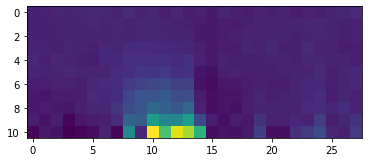

In [35]:
nmda_apic = nmda_evts.iloc[nmda_evts.index.get_level_values('Type')=='apic']

nmda_apic_cc = np.vstack(nmda_apic['norm_cc'])
nmda_apic_cc
fig, ax = plt.subplots()
ax.imshow(nmda_apic_cc)
plt.show()

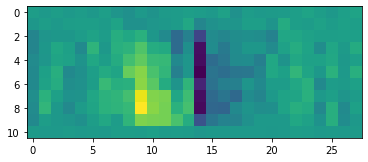

In [33]:
nmda_basal = nmda_evts.iloc[nmda_evts.index.get_level_values('Type')=='dend']

nmda_basal_cc = np.vstack(nmda_basal['norm_cc'])
nmda_basal_cc
fig, ax = plt.subplots()
ax.imshow(nmda_basal_cc)
plt.show()